# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [53]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.01 # швидкість навчання нейронної мережі
training_steps = 6000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [54]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)
x_test.shape

(10000, 784)

In [55]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features], stddev=0.1), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.out_layer(x, activation=1)

In [56]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    #regularization L2

    lambda_reg = 0.01

    l2_loss = (tf.nn.l2_loss(neural_net.layer_1.w)+
               tf.nn.l2_loss(neural_net.layer_2.w)+
               tf.nn.l2_loss(neural_net.out_layer.w)
               )

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred))) + l2_loss * lambda_reg

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, tf.int64))
    accuracy_value = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    #manual calculation without TensorFlow
    #list_of_predictions = list()
    #for i in range(len(y_pred)):
      #predicted_class = tf.argmax(y_pred[i])
      #if predicted_class == y_true[i]:
        #list_of_predictions.append(predicted_class)
    #accuracy_value = len(list_of_predictions) / len(y_pred)
    return accuracy_value



In [57]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    dw_1, dw_2, dw_output, db_1, db_2, db_output = g.gradient(loss, [neural_net.layer_1.w, neural_net.layer_2.w, neural_net.out_layer.w,neural_net.layer_1.b, neural_net.layer_2.b, neural_net.out_layer.b])
    # Обчислимо за ними значення градієнта
    optimizer.apply_gradients(zip((dw_1, dw_2, dw_output, db_1, db_2, db_output),(neural_net.layer_1.w, neural_net.layer_2.w, neural_net.out_layer.w,neural_net.layer_1.b, neural_net.layer_2.b, neural_net.out_layer.b)))


In [58]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
      pred = neural_net(batch_x)
      current_loss = cross_entropy(pred, batch_y)
      loss_history.append(current_loss)
      accuracy_history.append(accuracy(pred, batch_y))
      print(f"Step {step}, Loss: {current_loss.numpy()}, Accuracy: {accuracy_history[-1].numpy()}")

Step 100, Loss: 495.7490234375, Accuracy: 0.296875
Step 200, Loss: 127.0020523071289, Accuracy: 0.86328125
Step 300, Loss: 98.65031433105469, Accuracy: 0.9140625
Step 400, Loss: 76.84900665283203, Accuracy: 0.92578125
Step 500, Loss: 76.08988952636719, Accuracy: 0.93359375
Step 600, Loss: 52.73726272583008, Accuracy: 0.953125
Step 700, Loss: 40.501014709472656, Accuracy: 0.96875
Step 800, Loss: 32.12953186035156, Accuracy: 0.9921875
Step 900, Loss: 48.2065315246582, Accuracy: 0.96484375
Step 1000, Loss: 32.38929748535156, Accuracy: 0.9765625
Step 1100, Loss: 37.238651275634766, Accuracy: 0.96484375
Step 1200, Loss: 21.12830924987793, Accuracy: 1.0
Step 1300, Loss: 25.53702163696289, Accuracy: 0.984375
Step 1400, Loss: 17.36411476135254, Accuracy: 1.0
Step 1500, Loss: 35.57464599609375, Accuracy: 0.9765625
Step 1600, Loss: 23.881874084472656, Accuracy: 0.98828125
Step 1700, Loss: 33.71134948730469, Accuracy: 0.98046875
Step 1800, Loss: 30.46268081665039, Accuracy: 0.98828125
Step 1900, 

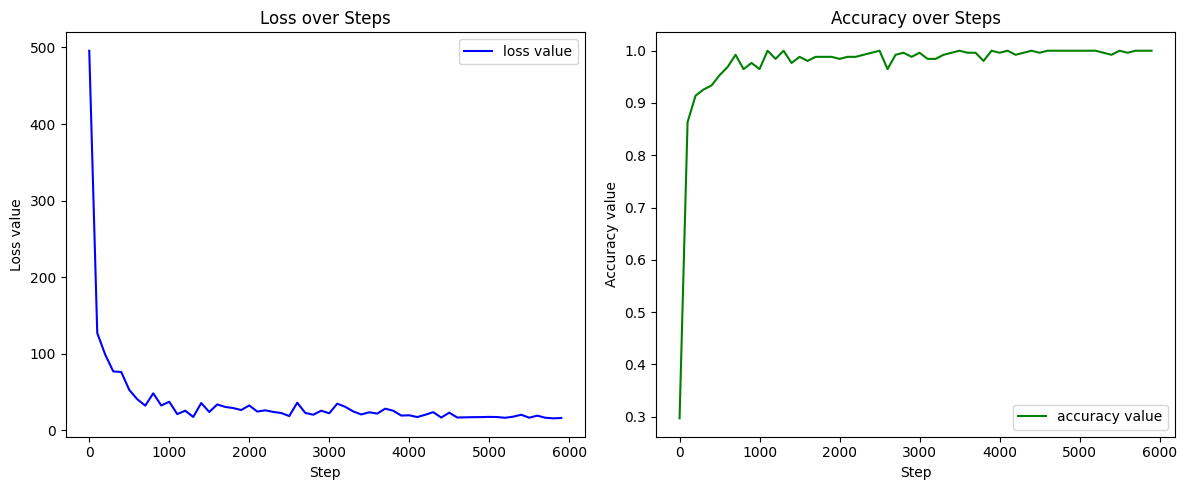

In [59]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

step_for_plot = list(range(0, training_steps, display_step))
loss_history_for_plot = [loss.numpy() for loss in loss_history]
accuracy_for_plot = [value.numpy() for value in accuracy_history]

plt.figure(figsize=(12,5))
#Виведіть графік функції втрат
plt.subplot(1,2,1)
plt.plot(step_for_plot, loss_history_for_plot, label="loss value", color="blue")

plt.xlabel("Step")
plt.ylabel("Loss value")
plt.title("Loss over Steps")
plt.legend()

# Виведіть графік точності
plt.subplot(1,2,2)
plt.plot(step_for_plot, accuracy_for_plot, label="accuracy value", color="green")
plt.xlabel("Step")
plt.ylabel("Accuracy value")
plt.title("Accuracy over Steps")
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# Обчисліть точність навченої нейромережі
predicted_training_data = neural_net(x_train)
train_accuracy = accuracy(predicted_training_data, y_train)
print(f"Accuracy on TRAIN DATA is {train_accuracy}")
# Тестування моделі на тестових даних
predicted_test_data = neural_net(x_test)
test_accuracy = accuracy(predicted_test_data, y_test)
print(f"Accuracy on TEST DATA is {test_accuracy.numpy()}")

Accuracy on TRAIN DATA is 0.9962166547775269
Accuracy on TEST DATA is 0.979200005531311


In [61]:
#Виведіть метрики якості для кожного класу навченої моделі
predicted_classes_test_data = tf.argmax(predicted_test_data, axis=1)

print(classification_report(predicted_classes_test_data, y_test, labels = [0,1,2,3,4,5,6,7,8,9]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       984
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1036
           3       0.98      0.97      0.98      1020
           4       0.98      0.98      0.98       987
           5       0.97      0.97      0.97       893
           6       0.98      0.98      0.98       953
           7       0.97      0.98      0.98      1017
           8       0.97      0.97      0.97       977
           9       0.97      0.98      0.97       998

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [62]:
#confusion matrix
#here is it obvious to observe what are major difficulties for the model to classificate and where the model messes up predicting another class,
#like class number 2: there are a lot of failure in prediction and confusions with class 7, 8 for example
print(confusion_matrix(predicted_classes_test_data, y_test, labels = [0,1,2,3,4,5,6,7,8,9]))

[[ 968    0    2    0    1    2    5    1    4    1]
 [   0 1125    0    0    0    0    3    4    0    3]
 [   2    2 1013    2    2    0    1   10    3    1]
 [   0    2    1  992    1   10    1    3    4    6]
 [   1    0    1    0  967    1    5    1    3    8]
 [   3    1    0    3    0  868    5    1    5    7]
 [   2    2    3    0    3    4  935    0    3    1]
 [   1    1    6    4    3    1    0  998    2    1]
 [   3    2    6    4    1    4    3    1  949    4]
 [   0    0    0    5    4    2    0    9    1  977]]


Predicted classes: [7 2 1 0 4 1 4 9 6 9]
True labels: [7 2 1 0 4 1 4 9 5 9]
[[1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2]]

Predicted classes: [1 7 2 4 5]
True labels: [1 7 2 4 5]
[[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


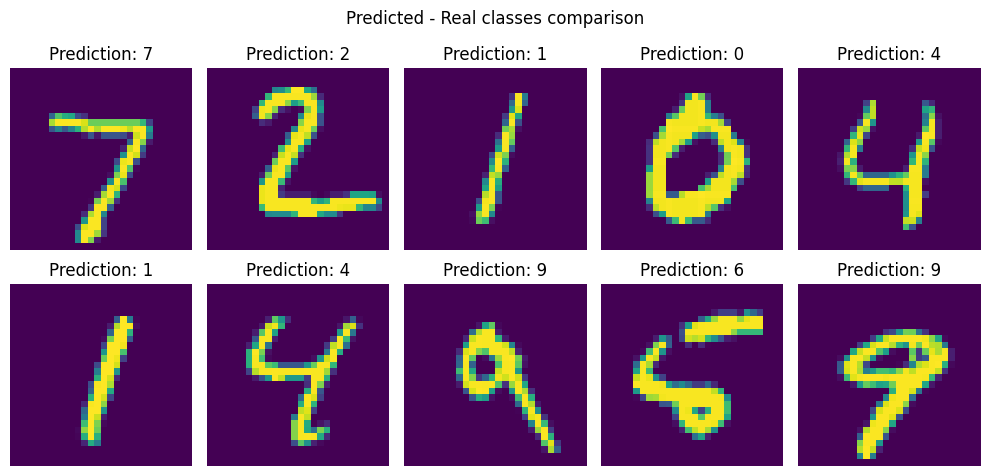

In [63]:
# Протестуйте навчену нейромережу на 10 зображеннях
#I selected 10 consequtive images from x_test(the first 10)
x_for_predictions = x_test[:10,:]
y_for_predictions = y_test[:10]
pred = neural_net(x_for_predictions)
predicted_classes = tf.argmax(pred, axis=1)

print("Predicted classes:", predicted_classes.numpy())
print("True labels:", y_for_predictions)
print(confusion_matrix(predicted_classes, y_for_predictions,labels = [0,1,2,3,4,5,6,7,8,9]))
print()

#З тестової вибірки візьміть 5 випадкових зображень і передайте їх у нейронну мережу.
#I selected 5 random images from x_test
indices = np.random.choice(len(x_test), 5, replace=False)
y_test_sample = y_test[indices]
x_test_sample = x_test[indices,:]
pedict_probabilities = neural_net(x_test_sample)
predicted_classes_ = tf.argmax(pedict_probabilities, axis=1)
print("Predicted classes:", predicted_classes_.numpy())
print("True labels:", y_test_sample)
print(confusion_matrix(predicted_classes_, y_test_sample,labels = [0,1,2,3,4,5,6,7,8,9]))


# Виведіть зображення та випишіть  поруч відповідь нейромережі.
figure, cells = plt.subplots(2,5,figsize=(10,5))
figure.suptitle("Predicted - Real classes comparison")
for i, cell in enumerate(cells.flatten()):
  cell.imshow(x_for_predictions[i].reshape(28,28), cmap="viridis")
  cell.set_title(f"Prediction: {predicted_classes[i]}")
  cell.axis("off")

plt.tight_layout()
plt.show()

In [64]:
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# точность и полнота предсказаний модели согласно classification report в зависимости от класса колеблется в пределах 97-99%, что говорит о высокой точности полноте предсказаний.
# результат обучения модели зависит очень от:
# 1. выбора исходных весов (матрица w), поэтому для того чтобы изначально случайно инициированный разброс весов не был слишком велик, был добавлен параметр stddev=0.1 в инициализацию w.
# 2. Таk же шаг обучения learning_rate был откорректирован на тy величину которая позволяет градиенту снижаться с достаточной скоростью и
# с одной стороны не быть слишком маленькой чтобы застрять в локальных минимумах, а с другой стороны не быть слишком большой чтобы перепрыгнуть минимум функции cross-validation.
# 3. Также была добавлена регуляризации в функцию потерь, за счёт которой удалось без существенного увеличения времени расчёта повысить точность почти на 0.2%
# 4. Увеличение количества эпох(С 3000 до 6000) существенно не повлияло на точность, хотя возможно при ещё большем количестве эпох результат был бы другой(потребуется привлечения дополнительных ресурсов и времени)
# тут уже нужно смотреть на цель: готовы ли мы жертвовать временем ради дополнительных сотых долей и процента точности и полноты.

# на основании результатов confusion matrix видно где модель ошибается больше всего.
# это классы:
# class 2: который модели путает с классом 4 и 7
# class 3: которая модель путает с классом5  9
# class 6, class 8: иногда модель путает с классом 5
# class 5: модель путает с классом 6 (что как раз можно увидеть и на визуализации выше, однако если несколько раз запускать модель - то иногда она предсказывает этот класс верно).

# обобщая можно сказать, что:
# модель показывает хорошую точность и полноту предсказаний(на тренинговой выборкe точность 99%, на тестовой выборки точно 97,9%), что говорит в Том числе об отсутствии переобучения.
# однако:
# 1. Если несколько раз запускать процесс обучения данной модели, то точность колеблется, иногда в средине цикла проскакивают аномальные значения функции ошибки(слишком высокая ошибка)
# и слишком низкая точность. Однако это бывает редко, но бывает, что свидетельствует о том что некоторые параметры возможно требуют более тонкой доработки для большей стабильности модели.
# 2. есть неточности в предсказаниях классов, написание которых часто схожи(кстати, в некоторых моментах данные классы может спутать и человек).

# на последних выборках из 10 последовательных классов и 5 случайно выбранных классов модель показывает те же самые тэндэнции.